In [1]:
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa
import numpy as np
import random
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import * 
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50

LABELS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
LABELS_INT = {'yes': 0, 'no': 1, 'up':2, 'down':3, 'left':4,
              'right':5, 'on':6, 'off':7, 'stop':8, 'go':9, 'silence':10 , 'unknown':11}



Using TensorFlow backend.


In [2]:
TRAIN_AUDIO_DATA = "../data/train/audio"
VALID_CSV = "../data/train/validation_list.txt"
TEST_AUDIO_DATA = "../data/test/audio"

all_files = []
for label in listdir(TRAIN_AUDIO_DATA):
    files = [join(label,f)  for f in listdir(join(TRAIN_AUDIO_DATA, label))]
    all_files +=  files
    
valid_files = pd.read_csv(VALID_CSV, header=None).iloc[:,0].values
train_files = [f for f in all_files if f not in valid_files]

print("Size of train: {} and valid data {}".format(len(train_files), len(valid_files)))

Size of train: 57930 and valid data 6798


In [3]:
def preprocessdata(files):
    # Examle of a file 'stop/6c968bd9_nohash_2.wav'
    data = []
    for f in files:
        # Get components
        components = f.split("/")
        label = components[0]
        uid = components[1].split("_")[0]

        if (label == '_background_noise_'):
            label = 'silence'
        
        if (not label in LABELS):
            label = 'unknown'
        
        label_code = LABELS_INT[label]
        path = join(TRAIN_AUDIO_DATA, f)        
        data.append([path, uid, label, label_code])
    
    return pd.DataFrame(data=data, columns=['file_path', 'user_id', 'label', 'label_code'])
        

df_train = preprocessdata(train_files)
df_valid = preprocessdata(valid_files)


#Shuffer df
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_valid = df_valid.sample(frac=1).reset_index(drop=True)

# Remove lalbel `unknown` and `silence`
df_train = df_train[df_train['label_code'] < 10]
df_valid = df_valid[df_valid['label_code'] < 10]

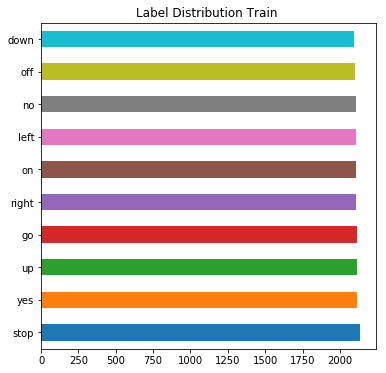

In [4]:
df_train['label'].value_counts().plot(kind='barh', figsize=(6,6), title='Label Distribution Train ');

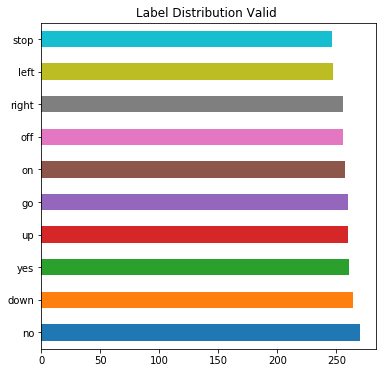

In [5]:
df_valid['label'].value_counts().plot(kind='barh', figsize=(6,6), title='Label Distribution Valid ');

In [6]:
x_train = df_train['file_path']
y_train = df_train['label_code']
x_valid = df_valid['file_path']
y_valid = df_valid['label_code']




In [7]:
def melspectrogram(audio, sample_rate):
    audio = audio.astype(float)
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=101)
    log_S = librosa.power_to_db(S, ref=np.max)
   
    return log_S

def random_segment(audio_signal, N):
    length = audio_signal.shape[0]
    if N < length:
        start = random.randint(0, length - N)
        audio_signal = audio_signal[start:start + N]
    else: 
        tmp = np.zeros((N,))
        start = random.randint(0, N - length)
        tmp[start: start + length] = audio_signal 
        audio_signal = tmp
        
    return audio_signal

def gen_melspec(wav_path, duration):
    def normalize(arr,min_,max_):
        return (arr-min_)/(max_ - min_)
    samplerate, test_sound = wavfile.read(wav_path)
    test_sound = test_sound
    N = int(duration*samplerate)
    segment_sound = random_segment(test_sound, N)
    log_melspectrogram = melspectrogram(segment_sound, samplerate).astype(np.float32)
#     im = Image.fromarray(np.uint8(cm.seismic(normalize(log_melspectrogram,-80,0))*255) )
#     arr = np.asarray(im.resize((image_size,image_size),Image.ANTIALIAS))
#     return arr[:,:,0:3]
    return np.expand_dims(log_melspectrogram.T, axis=0)


def generate_batch_data(x, Y, batch_size):
    while True:
        for i in range(0, len(x), batch_size):
            input, output = process_data(x[i:i+batch_size], Y[i:i+batch_size])
            
            yield (input, output)
            
            
def process_data(x, Y):    
    input = np.array([gen_melspec(file, 1.3) for file in x])
    input = input / 80.0
    output= to_categorical(Y, 12)
    assert(len(input) == len(output))
    return input, output


In [10]:
num_classes = 12
BATCH_SIZE = 100
NUM_EPOCH = 30

def build_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(20, 8), strides=(1, 1), input_shape=(1, 41, 101),
                     activation='relu', data_format= 'channels_first'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64,  kernel_size=(10, 4), strides=(1, 1),  data_format= 'channels_first',
                     activation='relu'))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    

    model.compile(loss = "categorical_crossentropy", 
                        optimizer = optimizers.Adagrad(lr=0.0001), metrics=["accuracy"])
    
    return model


model = build_model()

In [11]:
x_valid_processed, Y_valid_processed = process_data(x_valid, y_valid)
print("Finish process x_valid, y_valid")

   
model_path = "models/best_model.hdf5"        
    
checkpoint = ModelCheckpoint(model_path, monitor='val_acc',
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_acc',
                                  min_delta=0,
                                  patience=4,
                                  mode='auto')

model.fit_generator(generate_batch_data(x_train, y_train, BATCH_SIZE),
                        steps_per_epoch = int(len(x_train) / BATCH_SIZE), epochs=NUM_EPOCH, 
                        validation_data = (x_valid_processed, Y_valid_processed), shuffle=True,
                        callbacks = [checkpoint, early_stopping]
                     )

Finish process x_valid, y_valid
Epoch 1/30
211/211 [==============================] - 439s 2s/step - loss: 1.5887 - acc: 0.4858 - val_loss: 2.9769 - val_acc: 0.1048

Epoch 00001: val_acc improved from -inf to 0.10477, saving model to models/best_model.h5


OSError: Unable to create file (unable to open file: name = 'models/best_model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
# Read more about the meaning of name file
# Split 
file = join(TRAIN_AUDIO_DATA, 'stop/6c968bd9_nohash_2.wav')
ipd.Audio(file)

